# < 7. 인물사진을 만들어 보자 >

## [루브릭]
1. 인물모드 사진을 성공적으로 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

---

## 1. 필요한 라이브러리 import

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

---

## 2. 사진 준비하기

(800, 800, 3)


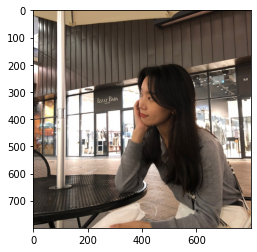

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/img.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show() 

---

## 3. 세그멘테이션

- 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용되는데 그중에서 DeepLab이라는 세그멘테이션 모델을 이용
- DeepLab 알고리즘
    - https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/
    - 적은 파라미터로 필터가 더 넓은 영역을 보게 하기 위해 atrous convolution을 사용한다

In [3]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f810cc845b0>)

In [4]:
#pixelLib로 세그멘테이션 모델 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력

segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
#Pascalvoc의 lable name은 다음과 같다.

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

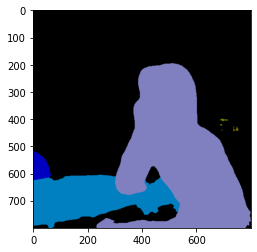

In [7]:
plt.imshow(output)
plt.show()

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bus
chair
diningtable
person


In [9]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
colormap[15]  # 사람을 나타내는 colormap

array([192, 128, 128])

In [11]:
seg_color = (128,128,192)       # output이 BGR로 되어있기 때문에 변경

(800, 800)


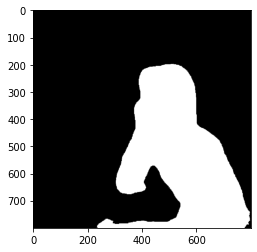

In [12]:
# 물체가 있으면 1, 없으면 0 으로
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

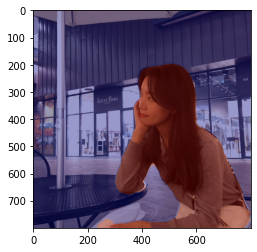

In [13]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

---

## 4. 이미지 blur 처리

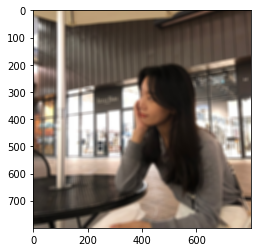

In [14]:
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### blur()
- 이미지를 흐리게할 때 사용

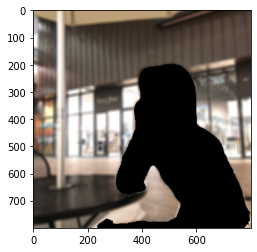

In [15]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### cv2.bitwise()
- 비트 연산을 진행하는 함수
- and : 두 이미지의 요소별 논리곱을 계산
    - 반전된 세그멘테이션 결과를 이용해서 이미지와 and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다
- not : 이미지의 값을 비트 단위로 파악하며 해당 비트에 대해 not연산을 진행
    - 원래 배경이 0, 사람이 255였으니 not 연산을 하고 나면 배경은 255, 사람은 0

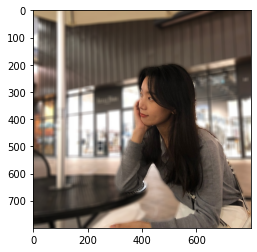

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

## 5. 다양한 사진에 해보기 - (1) 사람

(800, 600, 3)


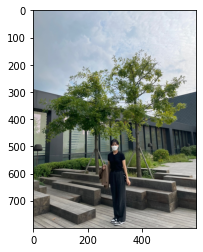

(594, 600, 3)


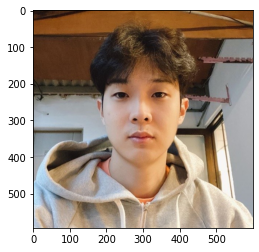

(960, 640, 3)


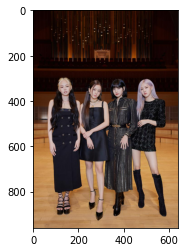

(409, 600, 3)


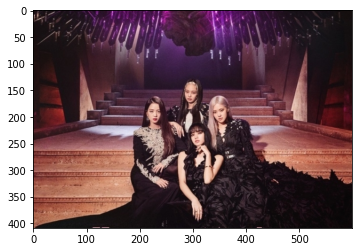

In [17]:
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_1.jpg'  
img_orig1 = cv2.imread(img_path1) 

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_2.jpg'  
img_orig2 = cv2.imread(img_path2) 

img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_3.jpg'  
img_orig3 = cv2.imread(img_path3) 

img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_4.jpg'  
img_orig4 = cv2.imread(img_path4) 

print(img_orig1.shape)
plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig4.shape)
plt.imshow(cv2.cvtColor(img_orig4, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
# 모델에 이미지 입력
segvalues1, output1 = model.segmentAsPascalvoc(img_path1)
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)
segvalues4, output4 = model.segmentAsPascalvoc(img_path4)

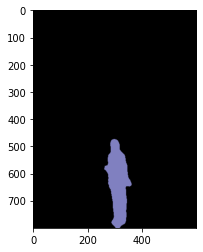

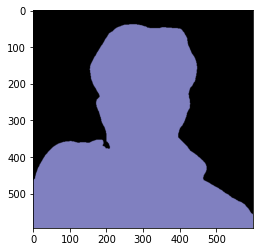

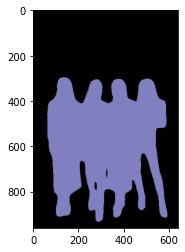

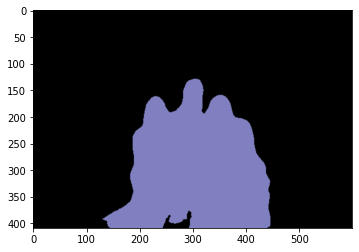

In [19]:
plt.imshow(output1)
plt.show()

plt.imshow(output2)
plt.show()

plt.imshow(output3)
plt.show()

plt.imshow(output4)
plt.show()

In [20]:
for class_id1 in segvalues1['class_ids']:
    print(LABEL_NAMES[class_id1])

for class_id2 in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id2])
    
for class_id3 in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id3])
    
for class_id4 in segvalues4['class_ids']:
    print(LABEL_NAMES[class_id4])

background
person
background
person
background
person
background
person


In [21]:
seg_color = (128,128,192)

(800, 800)


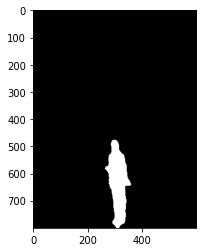

(800, 800)


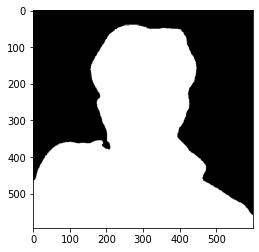

(800, 800)


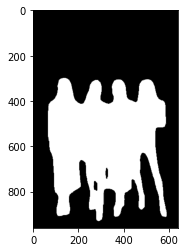

(800, 800)


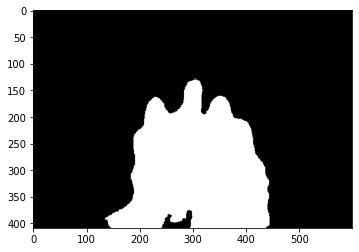

In [22]:
seg_map1 = np.all(output1==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map1, cmap='gray')
plt.show()

seg_map2 = np.all(output2==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

seg_map3 = np.all(output3==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map3, cmap='gray')
plt.show()

seg_map4 = np.all(output4==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map4, cmap='gray')
plt.show()

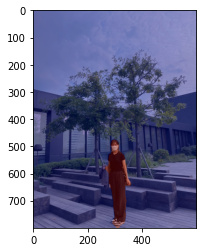

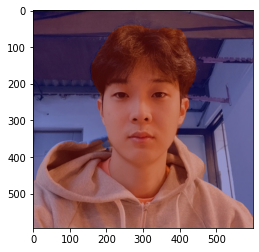

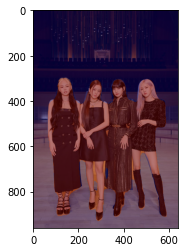

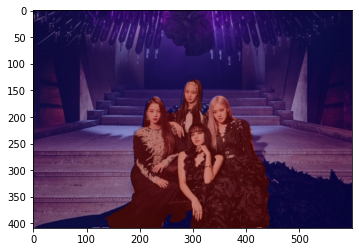

In [23]:
# 1
img_show1 = img_orig1.copy()

img_mask1 = seg_map1.astype(np.uint8) * 255

color_mask1 = cv2.applyColorMap(img_mask1, cv2.COLORMAP_JET)

img_show1 = cv2.addWeighted(img_show1, 0.6, color_mask1, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show1, cv2.COLOR_BGR2RGB))
plt.show()

# 2
img_show2 = img_orig2.copy()

img_mask2 = seg_map2.astype(np.uint8) * 255

color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)

img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

# 3
img_show3 = img_orig3.copy()

img_mask3 = seg_map3.astype(np.uint8) * 255

color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)

img_show3 = cv2.addWeighted(img_show3, 0.6, color_mask3, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show3, cv2.COLOR_BGR2RGB))
plt.show()

# 4
img_show4 = img_orig4.copy()

img_mask4 = seg_map4.astype(np.uint8) * 255

color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)

img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

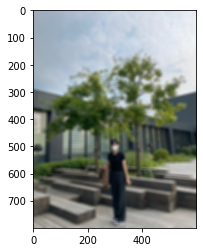

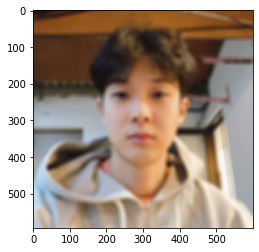

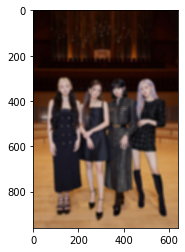

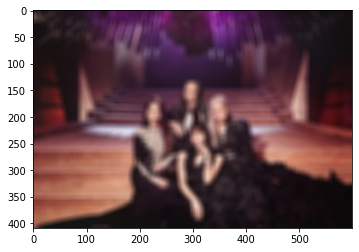

In [24]:
img_orig_blur1 = cv2.blur(img_orig1, (13, 13))  
plt.imshow(cv2.cvtColor(img_orig_blur1, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur2 = cv2.blur(img_orig2, (13, 13)) 
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur3 = cv2.blur(img_orig3, (13, 13))  
plt.imshow(cv2.cvtColor(img_orig_blur3, cv2.COLOR_BGR2RGB))
plt.show()

img_orig_blur4 = cv2.blur(img_orig4, (13, 13))  
plt.imshow(cv2.cvtColor(img_orig_blur4, cv2.COLOR_BGR2RGB))
plt.show()


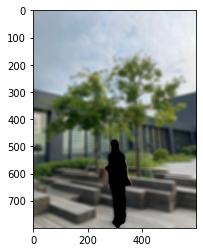

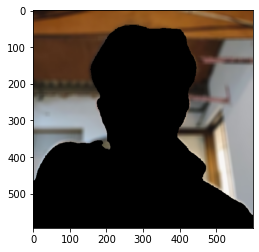

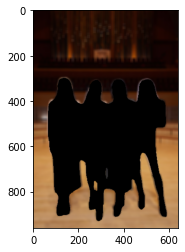

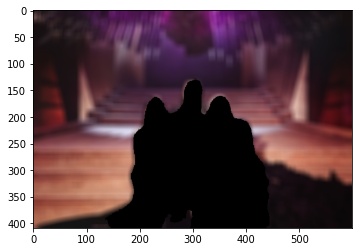

In [25]:
img_mask_color1 = cv2.cvtColor(img_mask1, cv2.COLOR_GRAY2BGR)
img_bg_mask1 = cv2.bitwise_not(img_mask_color1)
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask1)
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color3 = cv2.cvtColor(img_mask3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color3)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur3, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color4 = cv2.cvtColor(img_mask4, cv2.COLOR_GRAY2BGR)
img_bg_mask4 = cv2.bitwise_not(img_mask_color4)
img_bg_blur4 = cv2.bitwise_and(img_orig_blur4, img_bg_mask4)
plt.imshow(cv2.cvtColor(img_bg_blur4, cv2.COLOR_BGR2RGB))
plt.show()


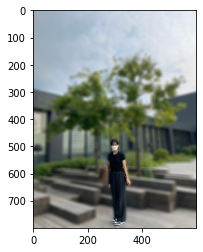

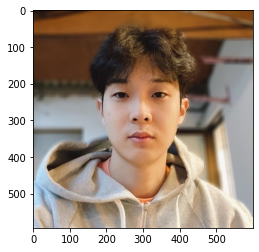

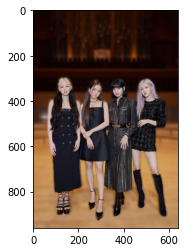

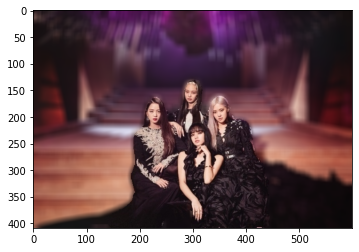

In [26]:
# 1
img_concat1 = np.where(img_mask_color1==255, img_orig1, img_bg_blur1)

plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.show()

# 2
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)

plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

# 3
img_concat3 = np.where(img_mask_color3==255, img_orig3, img_bg_blur3)

plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

# 4
img_concat4 = np.where(img_mask_color4==255, img_orig4, img_bg_blur4)

plt.imshow(cv2.cvtColor(img_concat4, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FEYOFS%2FbtrsfXQA4Vm%2FGce4zeSKzr3kSednIK0WU1%2Fimg.png)

- 내 팔이 잘려나간걸 볼 수 있다. 뿐만 아니라 전체적으로 몸 끝부분이 흐릿한걸 볼 수 있다. 신발도 구분이 명확하지 않다
- 구분해야 할 사람이 너무 작아서 제대로 구분이 안된게 아닌가 싶다

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FNpXOD%2FbtrsktVxi2m%2FsufH3e2kgKm8d2FCGEj4gk%2Fimg.png)

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fdiyu6N%2Fbtrsc0NT9WL%2Frw2iMJifuNzWaVhAeYI6r0%2Fimg.png)

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdrisxF%2FbtrspJpLuiP%2FiesNUwObYi88cCLoCbIXfk%2Fimg.png)

- 얼굴 옆을 제대로 인식하지 못해서 블러처리가 덜 되거나 머리까지 블러처리가 된 경우를 볼 수 있다
- 대체적으로 어깨 등 날카로운 경계에서는 제대로 블러처리가 안되는 것 같다. 
- 어두운 사진일 경우 블러처리가 잘 안되는 것 같다. 마지막 사진은 사람이 보기에도 저게 옷인가 할 수 있는데 역시나 제대로 블러처리가 되지 않았다

---

## 5. 다양한 사진에 해보기 - (2) 동물

(683, 1024, 3)


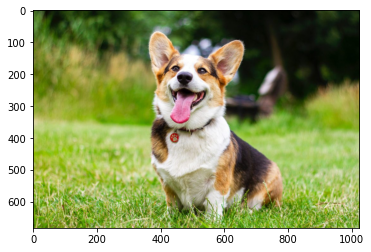

In [27]:
img_path_dog = os.getenv('HOME')+'/aiffel/human_segmentation/images/img_5.jpg'  
img_orig_dog = cv2.imread(img_path_dog) 

print(img_orig_dog.shape)
plt.imshow(cv2.cvtColor(img_orig_dog, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
segvalues_dog, output_dog = model.segmentAsPascalvoc(img_path_dog)

In [29]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

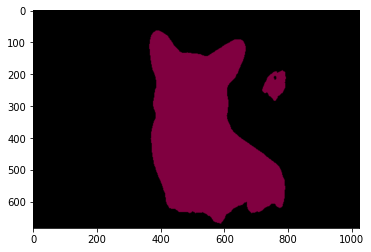

In [48]:
plt.imshow(output_dog)
plt.show()

In [31]:
for class_id_dog in segvalues_dog['class_ids']:
    print(LABEL_NAMES[class_id_dog])

background
dog


In [32]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [55]:
colormap[12]

array([ 64,   0, 128])

(683, 1024)


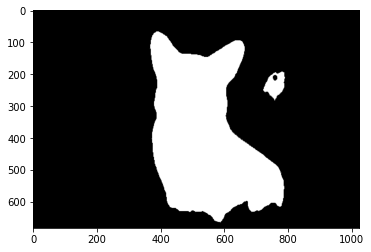

In [56]:
seg_color = (128,0,64)

seg_map_dog = np.all(output_dog==seg_color, axis=-1)
print(seg_map_dog.shape)
plt.imshow(seg_map_dog, cmap='gray')
plt.show()

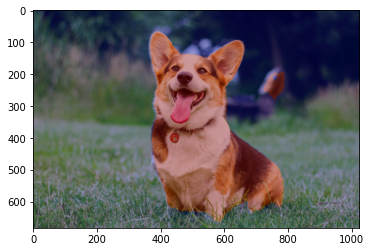

In [57]:
img_show_dog = img_orig_dog.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_dog = seg_map_dog.astype(np.uint8) * 255

color_mask_dog = cv2.applyColorMap(img_mask_dog, cv2.COLORMAP_JET)

img_show_dog = cv2.addWeighted(img_show_dog, 0.6, color_mask_dog, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_dog, cv2.COLOR_BGR2RGB))
plt.show()

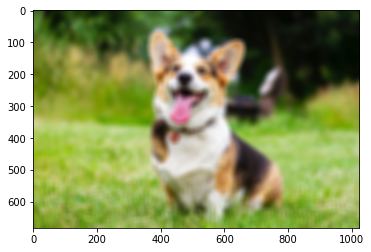

In [58]:
img_orig_blur_dog = cv2.blur(img_orig_dog, (20, 20))  # (13, 13)은 blurring kernel size를 말한다.
plt.imshow(cv2.cvtColor(img_orig_blur_dog, cv2.COLOR_BGR2RGB))
plt.show()

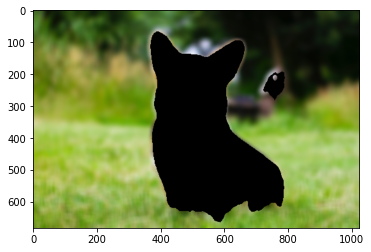

In [59]:
img_mask_color_dog = cv2.cvtColor(img_mask_dog, cv2.COLOR_GRAY2BGR)
img_bg_mask_dog = cv2.bitwise_not(img_mask_color_dog)
img_bg_blur_dog = cv2.bitwise_and(img_orig_blur_dog, img_bg_mask_dog)
plt.imshow(cv2.cvtColor(img_bg_blur_dog, cv2.COLOR_BGR2RGB))
plt.show()

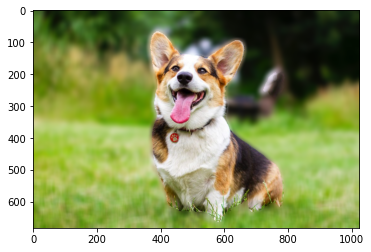

In [60]:
img_concat_dog = np.where(img_mask_color_dog==255, img_orig_dog, img_bg_blur_dog)
plt.imshow(cv2.cvtColor(img_concat_dog, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcjAbde%2FbtrspKJovN6%2FEmChozjahJa7Cb53mxj6K0%2Fimg.png)

- 강아지가 아닌 다른 물체도 같이 분리가 되었다
- 강아지 발의 분리가 잘 안된것 같다

---

## 6. 배경 바꾸기

(323, 500, 3)


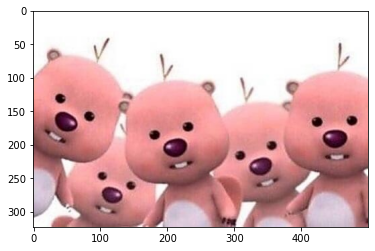

In [39]:
img_path_back = os.getenv('HOME')+ '/aiffel/human_segmentation/images/back.jfif' 
img_class_back = cv2.imread(img_path_back) 
print(img_class_back.shape)
plt.imshow(cv2.cvtColor(img_class_back, cv2.COLOR_BGR2RGB))
plt.show() 

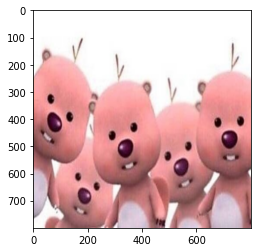

In [40]:
#사진 크기 맞춰주기
target_size = (800,800)
new_class = cv2.resize(img_class_back, target_size)
plt.imshow(cv2.cvtColor(new_class, cv2.COLOR_BGR2RGB))
plt.show() 

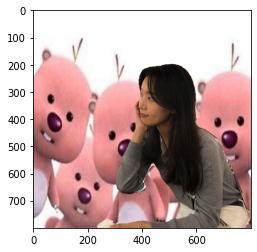

In [41]:
# 합성
img_concat = np.where(img_mask_color==255, img_orig, new_class)#255인곳은 원본 이미지 , 나머지는 교실배경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

## 7. 문제점 해결방법
- 인식이 잘 안되는 부분은 사진의 심도 정보를 가지고 있으면 인식률이 더 올라갈 것 같다. 심도의 변화량이 크다는 것은 심도가 급격하게 변한다는 말이고, 심도가 급격하게 변하는 곳은 object와 object가 분리되는 지점일 것이다. 따라서 심도 정보를 가지고 있으면, object의 겅계를 더 정확하게 구분할 수 있게 되므로 인식률이 올라갈 것이다. 심도는 두 개의 카메라를 이용하면 계산할 수 있을 것이다
- 경계 주변에서 발생하는 번짐현상은 블러처리의 알고리즘을 수정하면 되지 않을까 생각한다. 이 부분은 더 알아봐야겠다
- 머리카락부분 인식에 대해서 알아보다가 https://medium.com/deelvin-machine-learning/human-image-segmentation-experience-from-deelvin-5148a6cc71da 이런 글을 읽게 되었는데 더 많은 사진 데이터를 만들어서 신경망을 학습시키게 함으로써 문제를 해결하는 방법에 대해 나와있다.
- 문제점 해결방법에 대해서는 좀 더 알아봐야할 것 같다

---

## 8. 정리
- 참고 : https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb
- 이미지 세그멘테이션이라는 단어는 들어봤는데 그게 정확히 무얼 하는건지는 잘 몰랐는데 이번 프로젝트를 통해서 정확히 알게 되었다.
- 프로젝트 진행 중간에 메모리를 너무 많이 잡아먹는다는 에러가 떴었는데 이미지의 사이즈를 줄이고 kernel을 재시작하니까 해결되었다.
- 앞으로 이런 이미지 처리에 대해 자세히 공부하고 싶어졌다.